# Random Forest Prediction

In [47]:
# import packages
import pandas as pd
import os
import numpy as np
import seaborn as sns
import missingno as msno
import sklearn 
from plotnine import ggplot, aes, geom_line

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from skranger.ensemble import RangerForestRegressor

In [2]:
# Load data
trade_nodelist = pd.read_csv('../Output_datasets/Yearly_trade_data_prediction/trade_nodelist.csv')
trade_edgelist = pd.read_csv('../Output_datasets/Yearly_trade_data_prediction/trade_edgelist.csv')

In [3]:
trade_nodelist.columns

Index(['Unnamed: 0', 'year', 'gdp', 'total_population',
       'urban_population(%_of_total)', 'iso2', 'cnum', 'country', 'pays',
       'area', 'dis_int', 'landlocked', 'continent', 'citynum', 'langoff_1',
       'langoff_2', 'langoff_3', 'lang20_1', 'lang20_2', 'lang20_3',
       'lang20_4', 'lang9_1', 'lang9_2', 'lang9_3', 'lang9_4', 'colonizer1',
       'colonizer2', 'colonizer3', 'colonizer4', 'short_colonizer1',
       'short_colonizer2', 'short_colonizer3', 'iso_numeric'],
      dtype='object')

In [4]:
trade_edgelist.columns

Index(['Unnamed: 0', 'Period', 'Value', 'iso_o', 'iso_d', 'contig',
       'comlang_off', 'comlang_ethno', 'colony', 'comcol', 'curcol', 'col45',
       'smctry', 'dist', 'distcap', 'distw', 'distwces'],
      dtype='object')

In [5]:
# Drop lines where the origin is the same as destination
trade_edgelist = trade_edgelist.drop(trade_edgelist[trade_edgelist["iso_o"] == trade_edgelist["iso_d"]].index)

In [14]:
test = trade_edgelist.groupby(['iso_o', 'iso_d'])

In [17]:
# Create lagged value of trade
trade_edgelist['lag_value'] = trade_edgelist.groupby(['iso_o', 'iso_d'])['Value'].shift(-1)

<AxesSubplot:>

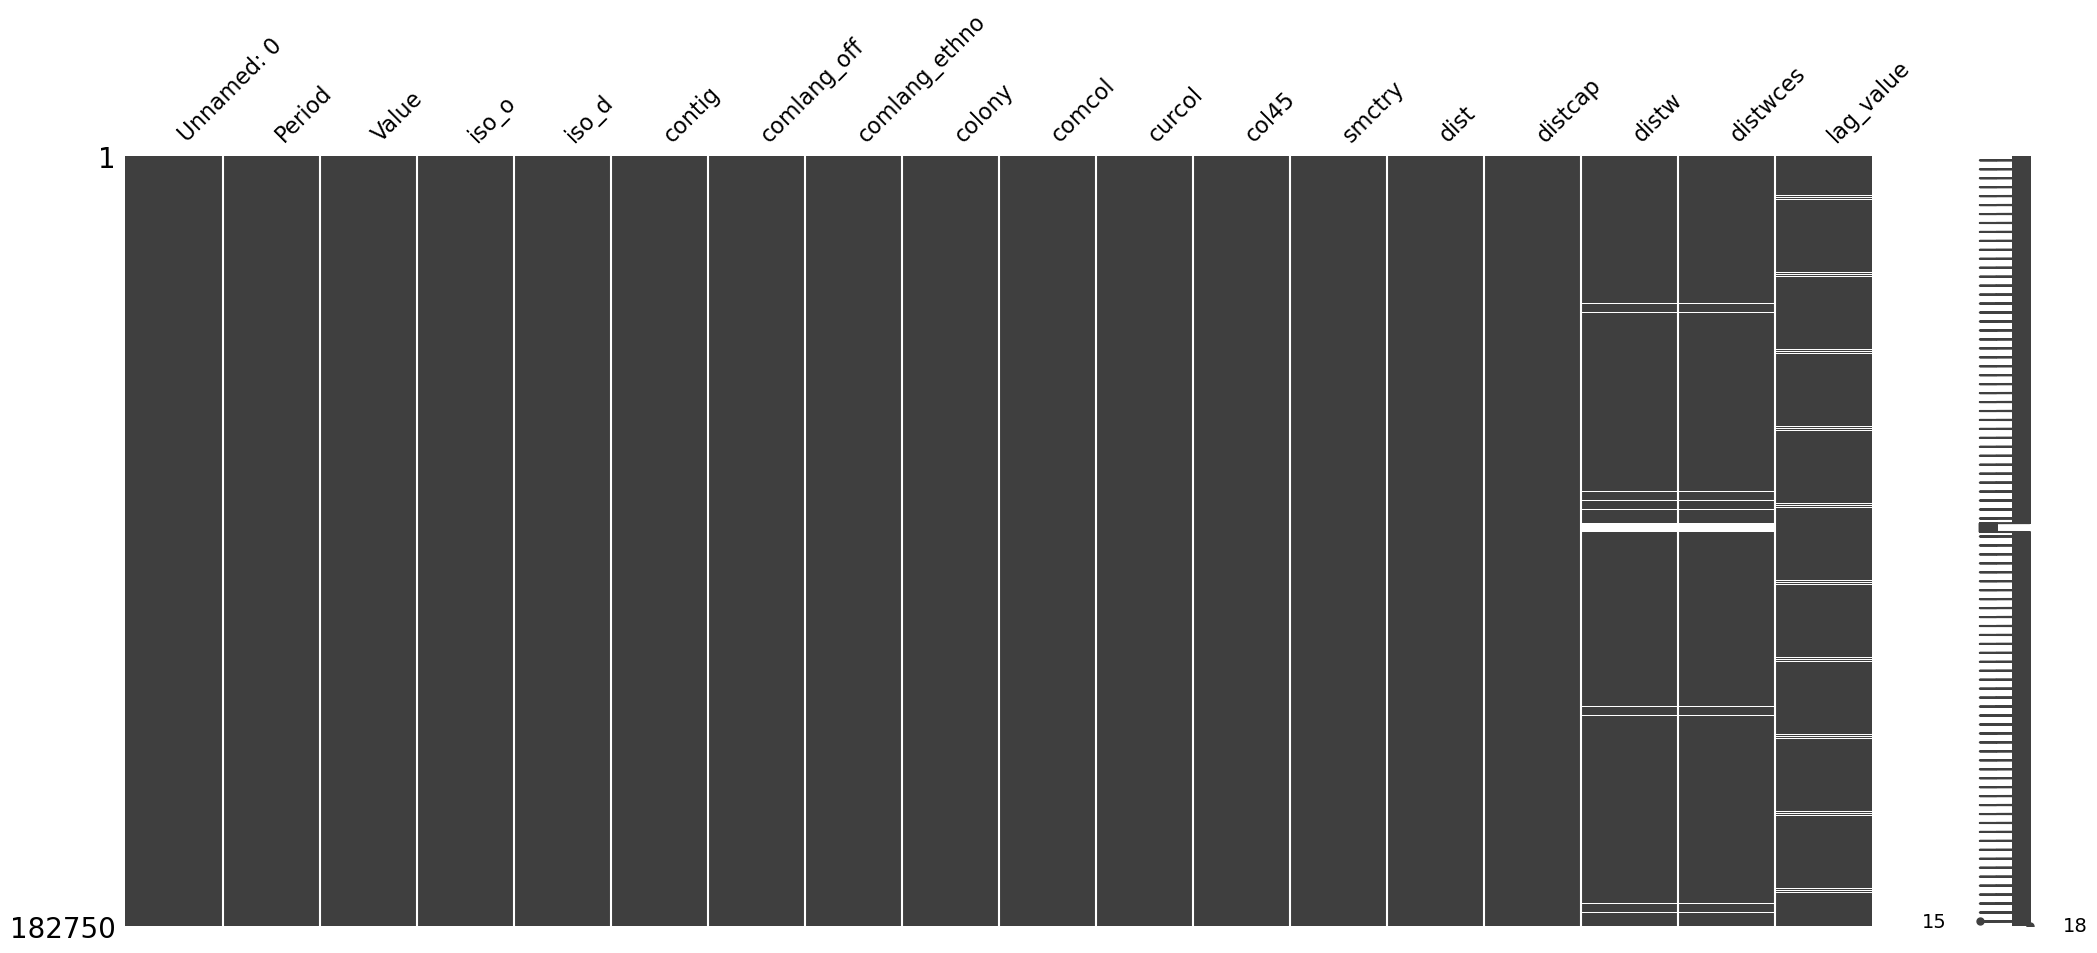

In [27]:
msno.matrix(trade_edgelist)

In [18]:
trade_edgelist

,Unnamed: 0,Period,Value,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,smctry,dist,distcap,distw,distwces,lag_value
25,25,1995,121775280,32,36,0,0,0,0,0,0,0,0,11801.364,11733.880,12044.574134,12018.272985,96345968.0
26,26,1996,96345968,32,36,0,0,0,0,0,0,0,0,11801.364,11733.880,12044.574134,12018.272985,103474288.0
27,27,1997,103474288,32,36,0,0,0,0,0,0,0,0,11801.364,11733.880,12044.574134,12018.272985,101764056.0
28,28,1998,101764056,32,36,0,0,0,0,0,0,0,0,11801.364,11733.880,12044.574134,12018.272985,86722197.0
29,29,1999,86722197,32,36,0,0,0,0,0,0,0,0,11801.364,11733.880,12044.574134,12018.272985,71213431.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184870,184870,2015,164038,894,858,0,0,0,0,0,0,0,0,8541.538,8541.538,8649.998621,8645.373081,278445.0
184871,184871,2016,278445,894,858,0,0,0,0,0,0,0,0,8541.538,8541.538,8649.998621,8645.373081,560035.0
184872,184872,2017,560035,894,858,0,0,0,0,0,0,0,0,8541.538,8541.538,8649.998621,8645.373081,178133.0
184873,184873,2018,178133,894,858,0,0,0,0,0,0,0,0,8541.538,8541.538,8649.998621,8645.373081,508299.0


<AxesSubplot:>

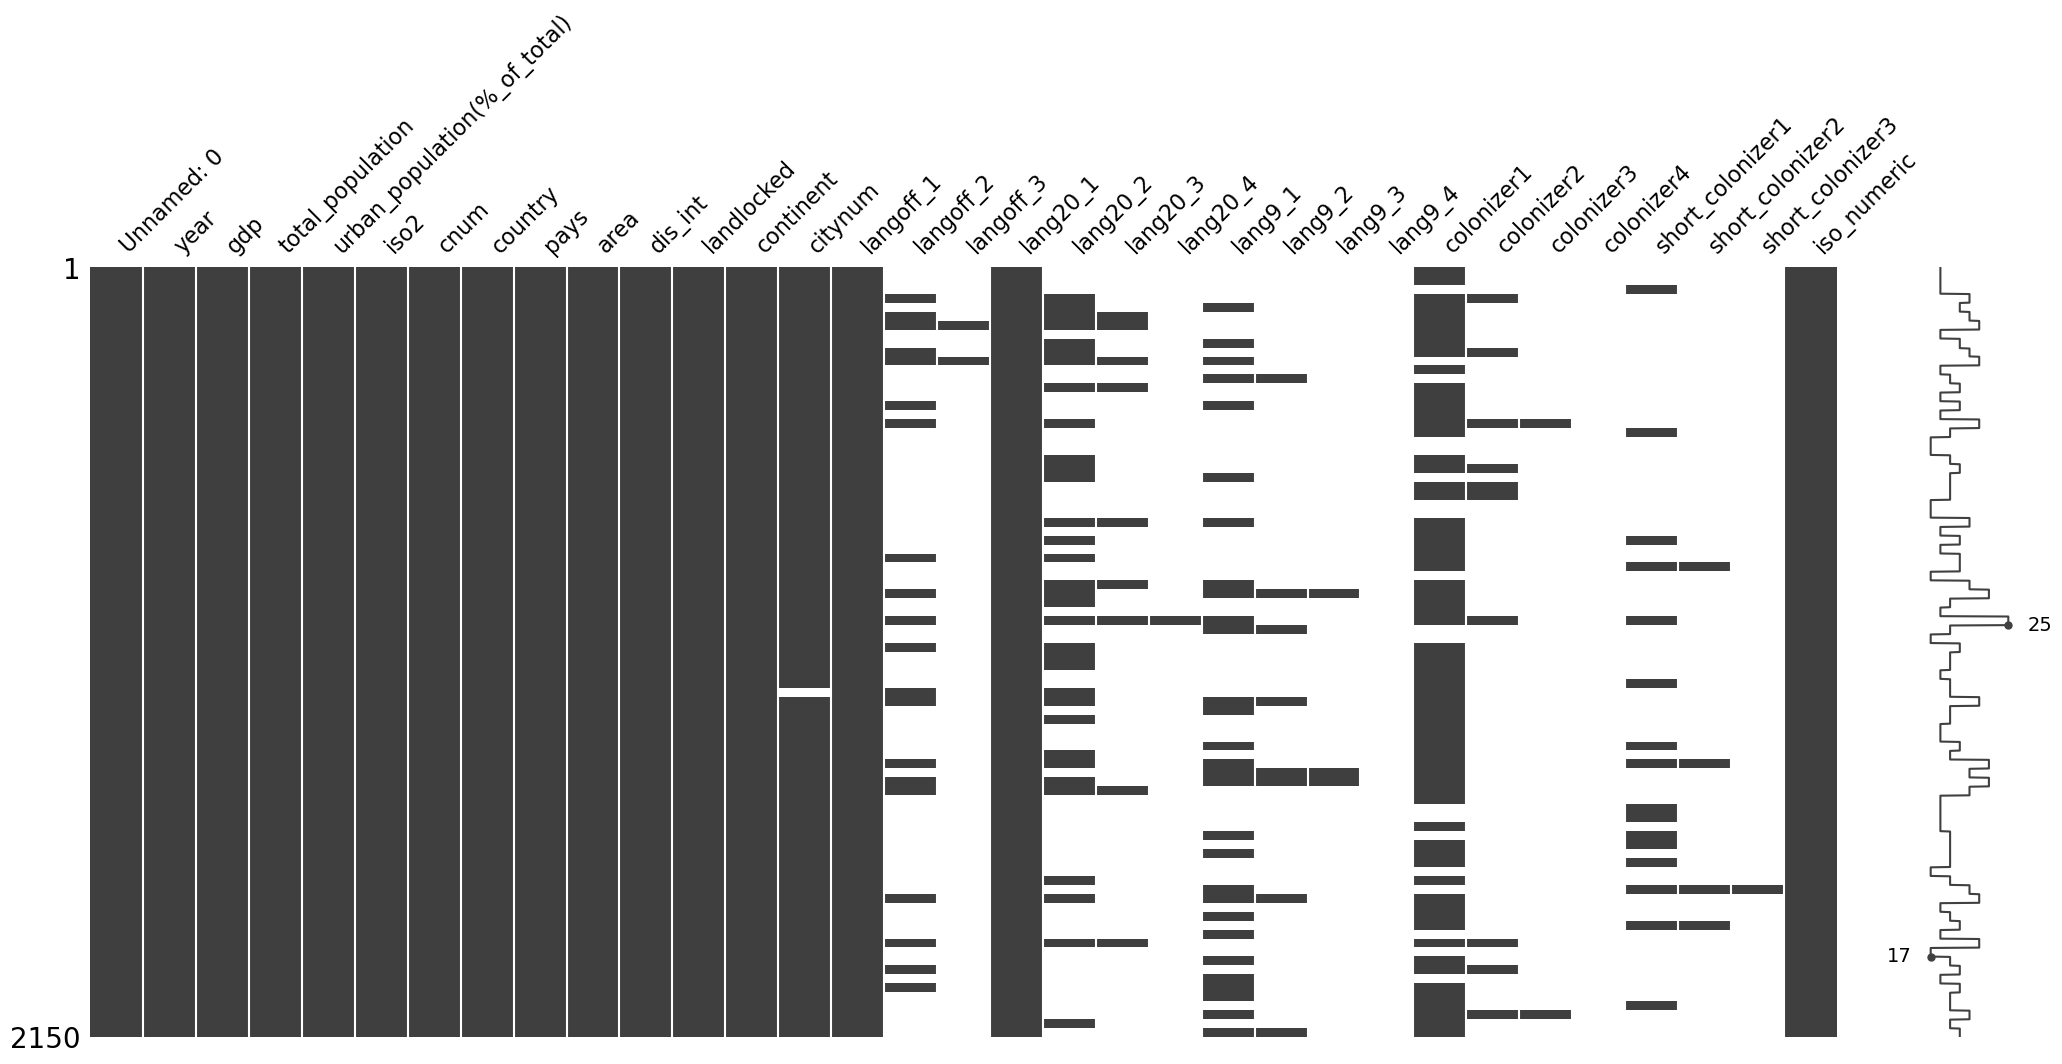

In [20]:
# Before mergin, let's look at missings in the nodelist 

msno.matrix(trade_nodelist)

In [21]:
# Drop variables missing too many observations
trade_nodelist.drop(['langoff_2', 'langoff_3', 'pays', 'lang20_1', 'lang20_2', 'lang20_3', 'lang20_4', 'lang9_1', 'lang9_2',
       'lang9_3', 'lang9_4', 'colonizer1', 'colonizer2', 'colonizer3',
       'colonizer4', 'short_colonizer1', 'short_colonizer2',
       'short_colonizer3'], axis=1, inplace=True)

In [22]:
# Convert string variables to categorical
trade_nodelist["f_continent"] = trade_nodelist["continent"].astype("category")
trade_nodelist["f_langoff_1"] = trade_nodelist["langoff_1"].astype("category")

In [23]:
trade_nodelist["f_langoff_1"].value_counts()

English           550
Spanish           375
French            175
Arabic            125
Portuguese         75
German             75
Romanian           50
Greek              50
Swedish            50
Slovenian          25
Lithuanian         25
Slovak             25
Serbo-Croatian     25
Thai               25
Polish             25
Norwegian          25
Maldivian          25
Malay              25
Macedonian         25
Korean             25
Latvian            25
Chinese            25
Kazakh             25
Japanese           25
Italian            25
Indonesian         25
Icelandic          25
Hungarian          25
Hebrew             25
Estonian           25
Dutch              25
Danish             25
Czech              25
Turkish            25
Name: f_langoff_1, dtype: int64

In [39]:
print(trade_nodelist.dtypes)

Unnamed: 0                         int64
year                               int64
gdp                              float64
total_population                 float64
urban_population(%_of_total)     float64
iso2                              object
cnum                               int64
country                           object
area                               int64
dis_int                          float64
landlocked                       float64
continent                         object
citynum                          float64
langoff_1                         object
iso_numeric                        int64
f_continent                     category
f_langoff_1                     category
dtype: object


In [24]:
# Merge once for origin and once for destination 
trade=pd.merge(trade_edgelist,trade_nodelist,how='left', left_on=['iso_o','Period'], right_on=['iso_numeric','year'],suffixes=('', '_o'))
trade=pd.merge(trade,trade_nodelist,how='left', left_on=['iso_d','Period'], right_on=['iso_numeric','year'],suffixes=('', '_d'))
trade

,Unnamed: 0,Period,Value,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,...,country_d,area_d,dis_int_d,landlocked_d,continent_d,citynum_d,langoff_1_d,iso_numeric_d,f_continent_d,f_langoff_1_d
0,25,1995,121775280,32,36,0,0,0,0,0,...,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,36,Pacific,English
1,26,1996,96345968,32,36,0,0,0,0,0,...,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,36,Pacific,English
2,27,1997,103474288,32,36,0,0,0,0,0,...,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,36,Pacific,English
3,28,1998,101764056,32,36,0,0,0,0,0,...,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,36,Pacific,English
4,29,1999,86722197,32,36,0,0,0,0,0,...,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,36,Pacific,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182745,184870,2015,164038,894,858,0,0,0,0,0,...,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,858,America,Spanish
182746,184871,2016,278445,894,858,0,0,0,0,0,...,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,858,America,Spanish
182747,184872,2017,560035,894,858,0,0,0,0,0,...,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,858,America,Spanish
182748,184873,2018,178133,894,858,0,0,0,0,0,...,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,858,America,Spanish


In [25]:
trade.columns

Index(['Unnamed: 0', 'Period', 'Value', 'iso_o', 'iso_d', 'contig',
       'comlang_off', 'comlang_ethno', 'colony', 'comcol', 'curcol', 'col45',
       'smctry', 'dist', 'distcap', 'distw', 'distwces', 'lag_value',
       'Unnamed: 0_o', 'year', 'gdp', 'total_population',
       'urban_population(%_of_total)', 'iso2', 'cnum', 'country', 'area',
       'dis_int', 'landlocked', 'continent', 'citynum', 'langoff_1',
       'iso_numeric', 'f_continent', 'f_langoff_1', 'Unnamed: 0_d', 'year_d',
       'gdp_d', 'total_population_d', 'urban_population(%_of_total)_d',
       'iso2_d', 'cnum_d', 'country_d', 'area_d', 'dis_int_d', 'landlocked_d',
       'continent_d', 'citynum_d', 'langoff_1_d', 'iso_numeric_d',
       'f_continent_d', 'f_langoff_1_d'],
      dtype='object')

<AxesSubplot:>

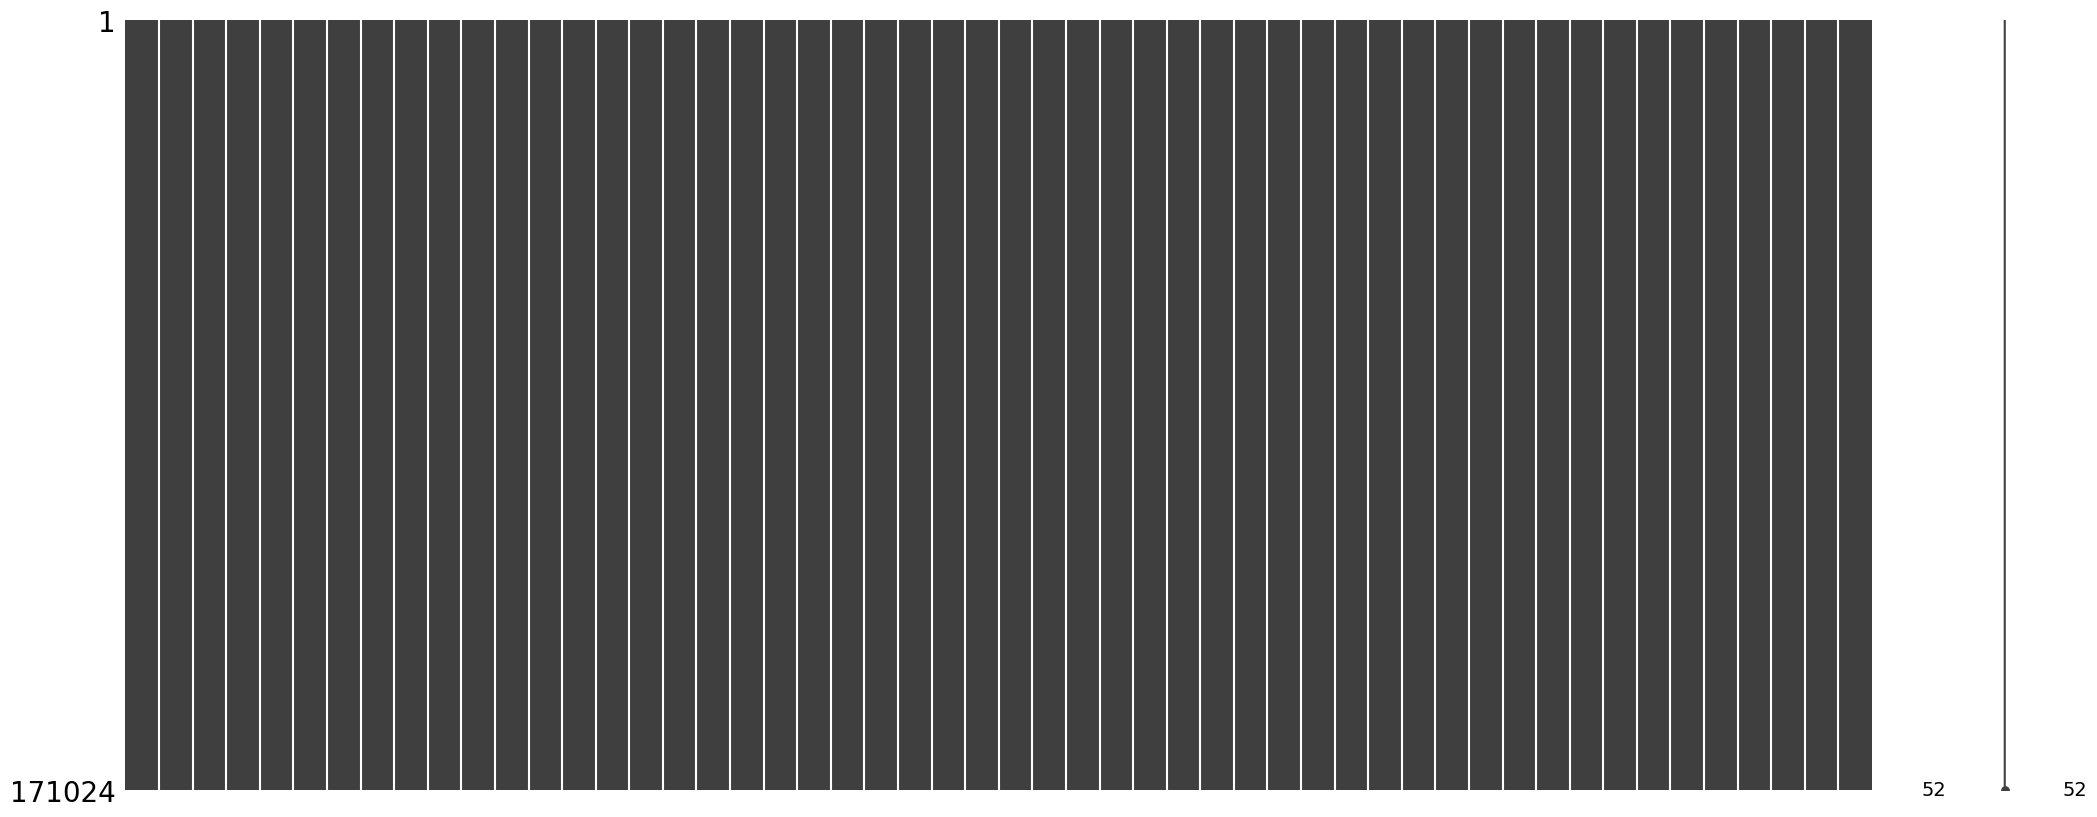

In [26]:
# Drop observations with missing data still
trade.dropna(inplace=True)
msno.matrix(trade)

In [28]:
trade

,Unnamed: 0,Period,Value,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,...,country_d,area_d,dis_int_d,landlocked_d,continent_d,citynum_d,langoff_1_d,iso_numeric_d,f_continent_d,f_langoff_1_d
0,25,1995,121775280,32,36,0,0,0,0,0,...,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,36,Pacific,English
1,26,1996,96345968,32,36,0,0,0,0,0,...,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,36,Pacific,English
2,27,1997,103474288,32,36,0,0,0,0,0,...,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,36,Pacific,English
3,28,1998,101764056,32,36,0,0,0,0,0,...,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,36,Pacific,English
4,29,1999,86722197,32,36,0,0,0,0,0,...,Australia,7686848,1042.81670,0.0,Pacific,25.0,English,36,Pacific,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182744,184869,2014,284774,894,858,0,0,0,0,0,...,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,858,America,Spanish
182745,184870,2015,164038,894,858,0,0,0,0,0,...,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,858,America,Spanish
182746,184871,2016,278445,894,858,0,0,0,0,0,...,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,858,America,Spanish
182747,184872,2017,560035,894,858,0,0,0,0,0,...,Uruguay,176215,157.89023,0.0,America,25.0,Spanish,858,America,Spanish


In [53]:
data = trade[["Period", "Value", "iso_o", "iso_d", "contig", "comlang_off", "comlang_ethno", "colony", "comcol", "curcol", "col45", "smctry", "dist", "distcap",'distcap', 'distw', 'distwces',
       'year', 'gdp', 'total_population', 'urban_population(%_of_total)',
       'area', 'dis_int', 'landlocked',
       'citynum', 'gdp_d', 'total_population_d',
       'urban_population(%_of_total)_d', 'cnum_d',
       'area_d', 'dis_int_d', 'landlocked_d', 'citynum_d', 'lag_value']]
data_train = data[(data["Period"] >= 1995) & (data["Period"] <= 1999)]
data_test = data[(data["Period"] == 2000)]
X_train= data_train.drop(['Value'], axis=1)
X_test= data_test.drop(['Value'], axis=1)
y_train = data_train['Value']
y_test = data_test['Value']

In [41]:
data

,Period,Value,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,...,total_population_d,urban_population(%_of_total)_d,cnum_d,area_d,dis_int_d,landlocked_d,citynum_d,lag_value,f_continent,f_langoff_1
0,1995,121775280,32,36,0,0,0,0,0,0,...,18004882.0,84.898,36,7686848,1042.81670,0.0,25.0,96345968.0,America,Spanish
1,1996,96345968,32,36,0,0,0,0,0,0,...,18224767.0,84.767,36,7686848,1042.81670,0.0,25.0,103474288.0,America,Spanish
2,1997,103474288,32,36,0,0,0,0,0,0,...,18423037.0,84.636,36,7686848,1042.81670,0.0,25.0,101764056.0,America,Spanish
3,1998,101764056,32,36,0,0,0,0,0,0,...,18607584.0,84.503,36,7686848,1042.81670,0.0,25.0,86722197.0,America,Spanish
4,1999,86722197,32,36,0,0,0,0,0,0,...,18812264.0,84.370,36,7686848,1042.81670,0.0,25.0,71213431.0,America,Spanish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182744,2014,284774,894,858,0,0,0,0,0,0,...,3391662.0,94.945,858,176215,157.89023,0.0,25.0,164038.0,Africa,English
182745,2015,164038,894,858,0,0,0,0,0,0,...,3402818.0,95.045,858,176215,157.89023,0.0,25.0,278445.0,Africa,English
182746,2016,278445,894,858,0,0,0,0,0,0,...,3413766.0,95.144,858,176215,157.89023,0.0,25.0,560035.0,Africa,English
182747,2017,560035,894,858,0,0,0,0,0,0,...,3422200.0,95.240,858,176215,157.89023,0.0,25.0,178133.0,Africa,English


In [54]:
print(data.dtypes)


Period                              int64
Value                               int64
iso_o                               int64
iso_d                               int64
contig                              int64
comlang_off                         int64
comlang_ethno                       int64
colony                              int64
comcol                              int64
curcol                              int64
col45                               int64
smctry                              int64
dist                              float64
distcap                           float64
distcap                           float64
distw                             float64
distwces                          float64
year                                int64
gdp                               float64
total_population                  float64
urban_population(%_of_total)      float64
area                                int64
dis_int                           float64
landlocked                        

In [57]:
# Train using 5 years and predict one year plus grid search

#regr = RandomForestRegressor(max_depth=5, random_state=42, n_jobs = -1)
regr = RangerForestRegressor(importance="impurity",max_depth=5, seed=42, n_jobs = -1)

tune_grid = {"mtry": [8, 10, 12], "min_node_size": [5, 10, 15]}

rf_random = GridSearchCV(
    regr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

trade_out = pd.DataFrame()
for year in range(1995, 2014):
    print(year)
    data_train = data[(data["Period"] >= year) & (data["Period"] <= year + 4)]
    data_test = data[(data["Period"] == year + 5)]
    X_train= data_train.drop(['Value'], axis=1)
    X_test= data_test.drop(['Value'], axis=1)
    y_train = data_train['Value']
    y_test = data_test['Value']

    rf_random.fit(X_train, y_train)
    y_predic = rf_random.predict(X_test)

    X_test['target'] = y_test
    X_test ['prediction'] = y_predic
   
    trade_out = pd.concat([trade_out, X_test])
    

1995
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .min_node_size=5, mtry=8;, score=-2239399933.718 total time=   0.6s
[CV 2/5] END .min_node_size=5, mtry=8;, score=-1694258400.282 total time=   0.6s
[CV 3/5] END .min_node_size=5, mtry=8;, score=-1341795167.911 total time=   0.6s
[CV 4/5] END ..min_node_size=5, mtry=8;, score=-651415502.118 total time=   0.6s
[CV 5/5] END .min_node_size=5, mtry=8;, score=-4000480748.931 total time=   0.6s
[CV 1/5] END min_node_size=5, mtry=10;, score=-1959950259.107 total time=   0.7s
[CV 2/5] END min_node_size=5, mtry=10;, score=-1340949416.914 total time=   0.6s
[CV 3/5] END .min_node_size=5, mtry=10;, score=-934784307.626 total time=   0.6s
[CV 4/5] END .min_node_size=5, mtry=10;, score=-554781507.179 total time=   0.7s
[CV 5/5] END min_node_size=5, mtry=10;, score=-3447589754.543 total time=   0.6s
[CV 1/5] END min_node_size=5, mtry=12;, score=-1851286995.001 total time=   0.6s
[CV 2/5] END min_node_size=5, mtry=12;, scor

In [58]:
trade_out

,Period,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,...,total_population_d,urban_population(%_of_total)_d,cnum_d,area_d,dis_int_d,landlocked_d,citynum_d,lag_value,target,prediction
5,2000,32,36,0,0,0,0,0,0,0,...,19028802.0,84.235,36,7686848,1042.81670,0.0,25.0,5.860930e+07,71213431,1.721501e+08
30,2000,32,40,0,0,0,0,0,0,0,...,8011566.0,60.213,40,83858,108.91960,1.0,25.0,8.137448e+07,81149089,1.352483e+08
55,2000,32,68,1,1,1,0,0,0,0,...,8592656.0,61.787,68,1098581,394.23016,1.0,25.0,2.057456e+07,20033861,2.571587e+08
80,2000,32,76,1,0,0,0,0,0,0,...,175873720.0,81.192,76,8511920,1097.35610,0.0,25.0,5.277761e+09,6478453841,3.163358e+09
105,2000,32,84,0,1,1,0,0,0,0,...,240406.0,45.398,84,22963,56.99649,0.0,9.0,0.000000e+00,0,6.202570e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182648,2018,894,826,0,1,1,1,0,0,1,...,66460344.0,83.398,826,244110,185.83461,0.0,25.0,1.306643e+08,185625025,6.854602e+08
182673,2018,894,834,1,1,0,0,1,0,0,...,58090443.0,33.776,834,945090,365.65405,0.0,25.0,2.045174e+08,180752530,1.359957e+09
182698,2018,894,840,0,1,1,0,0,0,0,...,326838199.0,82.256,842,9529106,1161.07400,0.0,25.0,1.864602e+08,194729947,1.624121e+09
182723,2018,894,854,0,0,0,0,0,0,0,...,20392723.0,29.358,854,274200,196.95523,1.0,25.0,3.978000e+03,3374,1.646897e+08
